### 3.3 - Deep Neural Network (DNN) model

In [1]:
# Load the packages and other tools
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
shap.initjs()
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import KalmanSmoother

C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Specific pre-processing to DL

In [ ]:
# load data
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data Preparation

In [ ]:
# Removing multicollinearity by dropping one of the variables in the pair
model1= model1.drop(['lg_Open','lg_Low','block-size'],axis=1)

In [ ]:
# Filling with the respective values
for i in range(len(model1)+1):
    for j in range(0,26): 
        model1[str(model1.columns[j]+'_t-1')]=''
        model1[str(model1.columns[j]+'_t-2')]=''

In [ ]:
model1.head(2)

In [ ]:
model1.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DL/tentativa.xlsx')

In [2]:
dl=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DL/tentativa.xlsx',index_col=0)

In [3]:
dl.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_hash-rate,lg_miners-revenue,n-transactions-total,...,GT_cryptocurrency_t-1,GT_cryptocurrency_t-2,GT_scam_t-1,GT_scam_t-2,lg_SP500_t-1,lg_SP500_t-2,lg_Oil_t-1,lg_Oil_t-2,Theft_t-1,Theft_t-2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,1.94591,6.921086,14.767149,14.575693,183961799.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,1.94591,6.938963,14.767149,14.575693,183961799.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Noise smoothing with tsmoothie library

* Keras Hypertuning - Grid Search

In [4]:
# Splitting 80% for training and 20% for testing
train = dl[:-323]
test = dl[-323:]
test=test.drop(['lg_price'], axis=1)


# Splitting 80% for training and 20% for validation
train = train[:-65]
len(train)
val = train[-65:]
len(test)

# prepare x_train, y_train
x_train = train.drop(['lg_price'], axis=1).values
y_train = train['lg_price'].values

# scaling
scale = MinMaxScaler(feature_range=(0,1))
x_train = scale.fit_transform(x_train)

# prepare x_test
x_test = test.values

# scaling
x_test = scale.transform(x_test)


# prepare x_val, y_val
x_val = val.drop(['lg_price'], axis=1).values
y_val = val['lg_price'].values

# scaling
from sklearn.preprocessing import MinMaxScaler
x_val = scale.fit_transform(x_val)

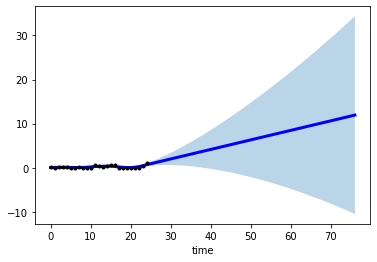

In [5]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
smoother.smooth(x_train)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_train= smoother.smooth_data

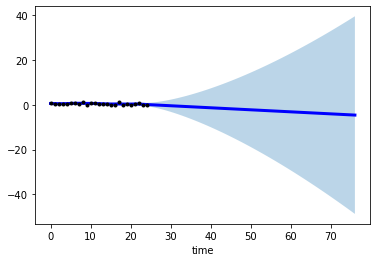

In [6]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
smoother.smooth(x_test)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_test= smoother.smooth_data

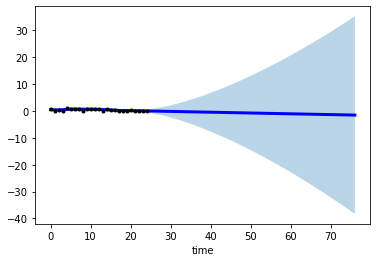

In [7]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
smoother.smooth(x_val)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_val= smoother.smooth_data

In [ ]:
def get_model(param):
        
    model = Sequential()
    model.add(Dense(param['unit_1'], activation=param['activ']))
    model.add(Dense(param['unit_2'], activation=param['activ']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=param['lr']), 
                  loss='mse', metrics=['mae'])
    
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from kerashypetune import KerasGridSearch
param_grid = {
    'unit_1': [128,64], 
    'unit_2': [64,32],
    'lr': [1e-2,1e-3], 
    'activ': ['elu','relu'],
    'epochs': 100, 
    'batch_size': 512
}

kgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)
kgs.search(x_train, y_train, validation_data=(x_val, y_val))

In [ ]:
kgs.scores

In [ ]:
kgs.best_score

In [ ]:
best_model=kgs.best_model
best_model

In [ ]:
#best_model.save('best_model')

In [8]:
from keras.models import load_model
best_model= load_model('best_model')

In [9]:
# Predicting the values for lg_price
pred = best_model.predict(x_test)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense
pred.shape

[[9.131264]
 [9.106229]
 [9.168395]
 [9.138497]
 [9.148055]]


(323, 1)

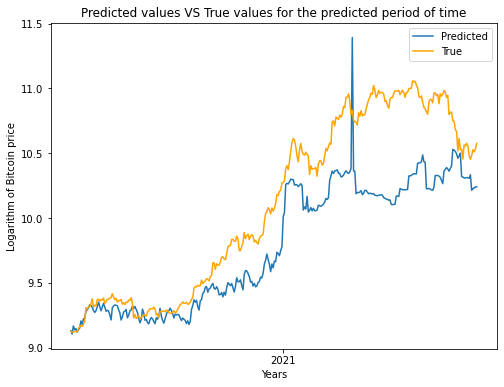

In [11]:
# Plotting the Predicted Bitcin price VS True Bitcoin price for the predicted period of time
original_test=dl.iloc[-323:,0]
date = original_test.index
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
plt.plot(date, pred)
plt.plot(date, original_test,color='orange')
plt.title('Predicted values VS True values for the predicted period of time')
plt.xlabel('Years')
plt.ylabel('Logarithm of Bitcoin price')
plt.legend(['Predicted', 'True'])
#plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_originalVSpred.jpeg')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
actual_price = dl[-323:]['lg_price'].values

# 1. MSE - Mean Squared Error
MSE= mean_squared_error(actual_price,pred)
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(actual_price,pred)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(actual_price,pred)
print('R^2 score: ',r2_score)

Mean Square Error:  0.158890590600971
Root Mean Square Error:  0.39861082599569597
sMAPE:  23.23384638683027
R^2 score:  0.6464746613494261


In [ ]:
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=0)
metric.head(3)

In [ ]:
# Defining a dictionary
d = {'Model': 'DL','MSE': MSE,'RMSE':RMSE,'sMAPE':sMAPE,'R^2 score': r2_score}

# Adding the most recent results to the existing dataframe
metric = metric.append(d, ignore_index=True)
metric.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx')

In [ ]:
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=1)
metric=metric.drop(['Unnamed: 0'],axis=1)
metric.head(3)

**(A) - Global Interpretability**

In [13]:
# compute SHAP values
explainer = shap.DeepExplainer(best_model, x_test)
shap_values = explainer.shap_values(x_test)

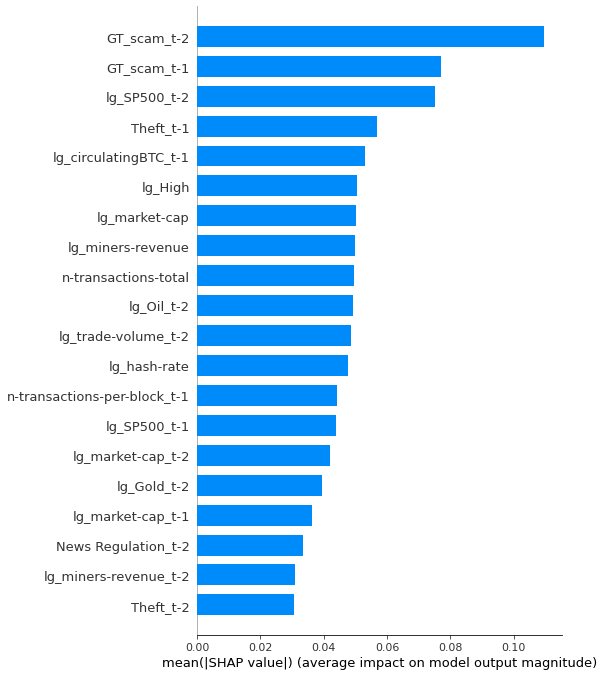

In [14]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test.columns,show=False)
f = plt.gcf()

In [ ]:
#f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_shap.jpeg',bbox_inches='tight',pad_inches=0.25)

**(B) - Local Interpretability**

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test.columns)

In [16]:
#plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_shap1.jpeg',bbox_inches='tight',pad_inches=0.25)

<Figure size 432x288 with 0 Axes>

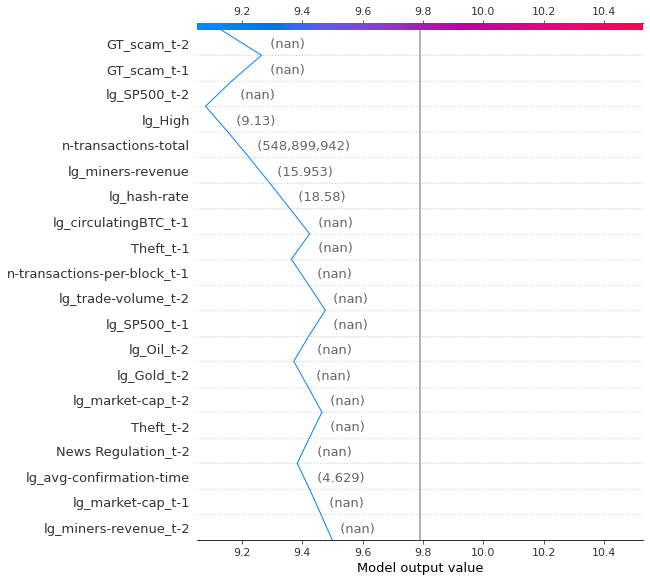

<Figure size 432x288 with 0 Axes>

In [17]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test.iloc[0,:], feature_names = test.columns.tolist())
f = plt.gcf()
f.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_shap2.jpeg',bbox_inches='tight',pad_inches=0.25)

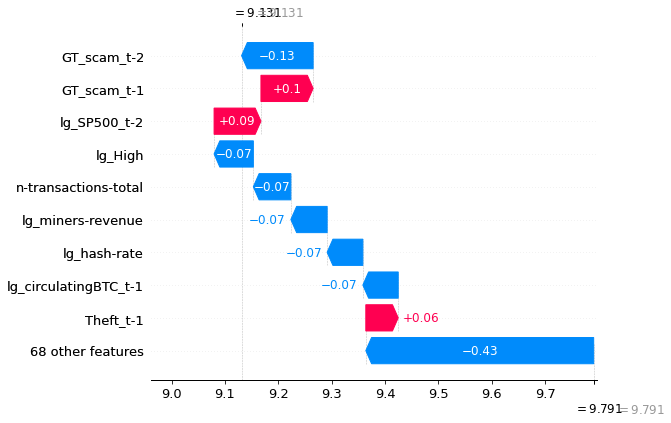

In [18]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names = test.columns)